In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transform
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch import optim

from IPython import display
display.set_matplotlib_formats('svg')



<ipython-input-27-a7fe7b3beffa>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# New Section

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar 19 01:07:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121


In [ ]:
transform = transform.Compose([
                               transform.ToTensor(),
                               transform.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [ ]:
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 28780285.78it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)


In [ ]:
print(f'train set shape:{train_data.data.shape}')
print(f'test set shape:{test_data.data.shape}')
print(f'classes: {train_data.classes}')

train set shape:(50000, 32, 32, 3)
test set shape:(10000, 32, 32, 3)
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
X,y = next(iter(train_loader))
print(f'X shape: {X.data.shape}')

X shape: torch.Size([32, 3, 32, 32])


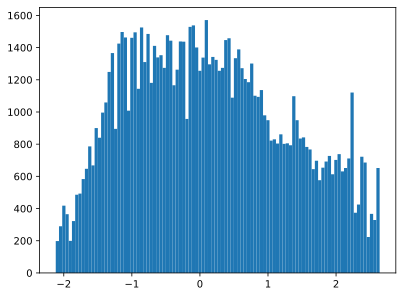

In [ ]:
plt.hist(X.data.numpy().flatten(),100);

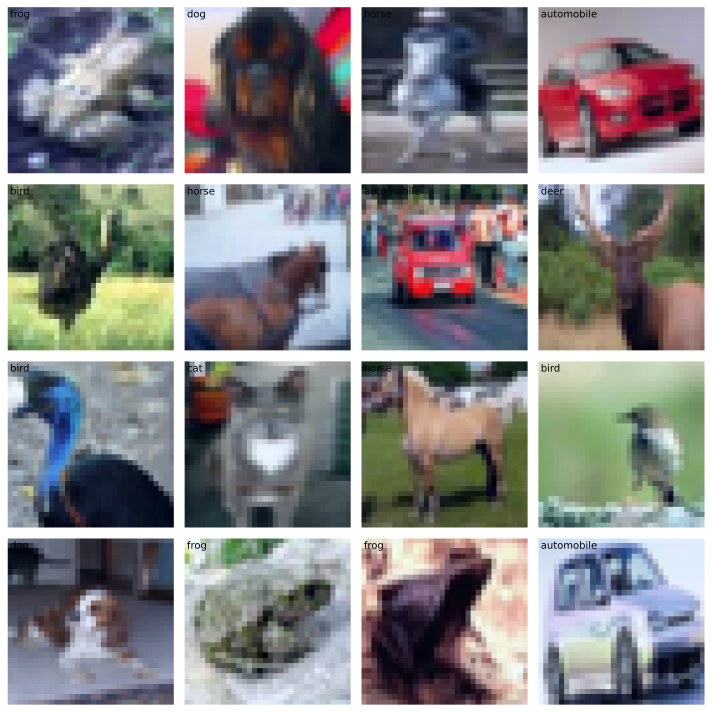

In [ ]:
fig,axs = plt.subplots(4,4, figsize=(10,10))
for(i,ax) in enumerate(axs.flatten()):
  pic=X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic)
  pic = pic/np.max(pic)

  label = train_data.classes[y[i]]
  ax.imshow(pic)
  ax.text(0,0,label, ha='left', va='top', color='k')
  ax.axis('off')


plt.tight_layout()
plt.show()


In [ ]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
summary(resnet.to(device), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
#for p in resnet.parameters():
 # p.requires_grad = False

In [ ]:
resnet.fc = nn.Linear(512, 10)

In [ ]:
resnet.to(device);

In [ ]:
criterion = nn.CrossEntropyLoss() #criterion
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=.9)

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU')
else:
    print('CUDA is available!  Training on GPU')

CUDA is available!  Training on GPU


In [ ]:
train_losslist = []
valid_loss_min = np.Inf

for epoch in range(1, 16):


    train_loss = 0.0
    valid_loss = 0.0

    #train the model

    resnet.train()
    for data, target in train_loader:

        if train_on_gpu:
           data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = resnet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    #validate
    resnet.eval()
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = resnet(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)


    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    train_losslist.append(train_loss)


    print(f'Epoch: {epoch} \tTraining Loss: {np.round(train_loss,6)} \tValidation Loss: {np.round(valid_loss,6)}')


    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({np.round(valid_loss_min,6)} --> {np.round(valid_loss,6)}).  Model saved!')
        torch.save(resnet.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.011448 	Validation Loss: 0.664907
Validation loss decreased (inf --> 0.664907).  Model saved!
Epoch: 2 	Training Loss: 0.646105 	Validation Loss: 0.591782
Validation loss decreased (0.664907 --> 0.591782).  Model saved!
Epoch: 3 	Training Loss: 0.502926 	Validation Loss: 0.574569
Validation loss decreased (0.591782 --> 0.574569).  Model saved!
Epoch: 4 	Training Loss: 0.409832 	Validation Loss: 0.577733
Epoch: 5 	Training Loss: 0.330069 	Validation Loss: 0.562441
Validation loss decreased (0.574569 --> 0.562441).  Model saved!
Epoch: 6 	Training Loss: 0.274058 	Validation Loss: 0.581634
Epoch: 7 	Training Loss: 0.223391 	Validation Loss: 0.635867
Epoch: 8 	Training Loss: 0.192672 	Validation Loss: 0.635856
Epoch: 9 	Training Loss: 0.161593 	Validation Loss: 0.638327
Epoch: 10 	Training Loss: 0.140251 	Validation Loss: 0.677956
Epoch: 11 	Training Loss: 0.118042 	Validation Loss: 0.694398
Epoch: 12 	Training Loss: 0.104748 	Validation Loss: 0.688143
Epoch: 13 

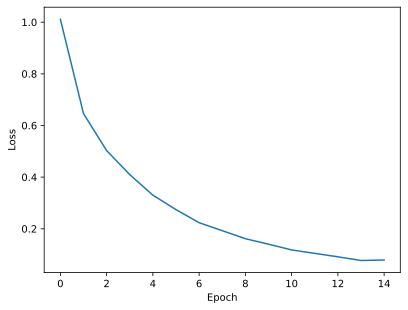

In [ ]:
n_epochs = [*range(15)]
plt.plot(n_epochs, train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
resnet.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

resnet.eval()

for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = resnet(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {np.round(test_loss,4)}\n')

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.5624

Test Accuracy of airplane: 82% (194/234)
Test Accuracy of automobile: 88% (217/246)
Test Accuracy of  bird: 74% (209/281)
Test Accuracy of   cat: 63% (161/253)
Test Accuracy of  deer: 77% (175/227)
Test Accuracy of   dog: 73% (184/250)
Test Accuracy of  frog: 90% (224/248)
Test Accuracy of horse: 85% (214/250)
Test Accuracy of  ship: 95% (246/258)
Test Accuracy of truck: 84% (225/265)

Test Accuracy (Overall): 81% (2049/2512)


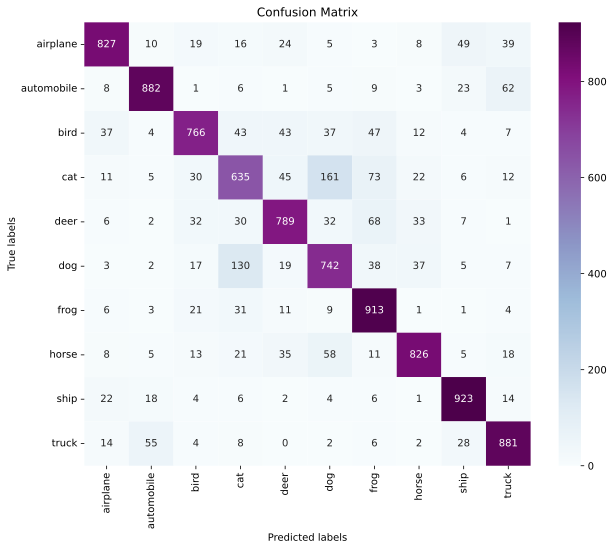

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


all_preds = []
all_targets = []

resnet.eval()

for data, target in test_loader:

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = resnet(data)
    _, pred = torch.max(output, 1)

    all_preds.extend(pred.cpu().numpy())
    all_targets.extend(target.cpu().numpy())



cm = confusion_matrix(all_targets, all_preds)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='BuPu', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()